# Ejercicio sobre CNNs

Carlos Checa Moreno

i02chmoc@uco.es

## Descargando los datos

In [1]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import kagglehub
from glob import glob
import shutil
import random

path = kagglehub.dataset_download("mdwaquarazam/agricultural-crops-image-classification")
print("Path to dataset files:", path)
def make_subsets_by_percentage(train_pct=0.7, val_pct=0.15, test_pct=0.15):
    assert abs(train_pct + val_pct + test_pct - 1.0) < 1e-5, "Los porcentajes deben sumar 1.0"

    original_data_dir = os.path.join(path, "Agricultural-crops")

    subsets = {
        "train": train_pct,
        "validation": val_pct,
        "test": test_pct
    }

    valid_extensions = ('.jpg', '.jpeg', '.png', '.gif', '.bmp')

    class_dirs = sorted([d for d in os.listdir(original_data_dir) if os.path.isdir(os.path.join(original_data_dir, d))])
    for class_name in class_dirs:
        class_path = os.path.join(original_data_dir, class_name)

        images = [f for f in os.listdir(class_path)
                 if os.path.isfile(os.path.join(class_path, f)) and f.lower().endswith(valid_extensions)]

        random.shuffle(images)

        total = len(images)
        train_end = int(total * train_pct)
        val_end = train_end + int(total * val_pct)

        splits = {
            "train": images[:train_end],
            "validation": images[train_end:val_end],
            "test": images[val_end:]
        }

        for subset_name, subset_images in splits.items():
            class_subset_dir = os.path.join("subsets", subset_name, class_name)
            os.makedirs(class_subset_dir, exist_ok=True)
            for img_name in subset_images:
                src_path = os.path.join(class_path, img_name)
                dst_path = os.path.join(class_subset_dir, img_name)
                shutil.copy(src_path, dst_path)

make_subsets_by_percentage(train_pct=0.7, val_pct=0.15, test_pct=0.15)

Path to dataset files: /kaggle/input/agricultural-crops-image-classification


El formato jpg no está admitido al hacer el fit del modelo, por lo cual he tenido que convertir todas las imagenes a jpeg

In [11]:
import os
from PIL import Image

def convert_jpg_to_jpeg(directory):
    for root, _, files in os.walk(directory):
        for filename in files:
            if filename.lower().endswith('.jpg'):
                old_path = os.path.join(root, filename)
                new_path = os.path.join(root, filename[:-4] + '.jpeg')

                try:
                    with Image.open(old_path) as img:
                        img.save(new_path, 'JPEG')

                    os.remove(old_path)
                    print(f"Convertido: {old_path} -> {new_path}")

                except Exception as e:
                    print(f"Error al convertir {old_path}: {str(e)}")

directory_path = "subsets"
convert_jpg_to_jpeg(directory_path)

Convertido: subsets/validation/Fox_nut(Makhana)/images6.jpg -> subsets/validation/Fox_nut(Makhana)/images6.jpeg
Convertido: subsets/validation/Fox_nut(Makhana)/images11.jpg -> subsets/validation/Fox_nut(Makhana)/images11.jpeg
Convertido: subsets/validation/Fox_nut(Makhana)/images24.jpg -> subsets/validation/Fox_nut(Makhana)/images24.jpeg
Convertido: subsets/validation/mustard-oil/image (15).jpg -> subsets/validation/mustard-oil/image (15).jpeg
Convertido: subsets/validation/mustard-oil/image (16).jpg -> subsets/validation/mustard-oil/image (16).jpeg
Convertido: subsets/validation/mustard-oil/image (5).jpg -> subsets/validation/mustard-oil/image (5).jpeg
Convertido: subsets/validation/mustard-oil/image (8).jpg -> subsets/validation/mustard-oil/image (8).jpeg
Convertido: subsets/validation/mustard-oil/image (11).jpg -> subsets/validation/mustard-oil/image (11).jpeg
Convertido: subsets/validation/mustard-oil/image (17).jpg -> subsets/validation/mustard-oil/image (17).jpeg
Convertido: subs

# Clasificación de Cultivos Agrícolas con Keras y Transfer Learning

Este cuaderno utiliza la base de datos [Agricultural crops images classification](https://www.kaggle.com/datasets/mahmoudelfar/agricultural-crops-images-classification) para realizar clasificación de imágenes con ayuda de transferencia de aprendizaje.

**Pasos:**
- Cargar los datos desde Kaggle.
- Preprocesamiento y división.
- Transfer learning con MobileNetV2.
- Entrenamiento y evaluación.
- Visualización de resultados.

In [2]:
# ipython-input-2-a316a824022d
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
# Change the number of units to match the number of classes in your dataset
outputs = layers.Dense(30, activation="softmax")(x) # Changed units to 30
# 30 units for 30 classes (assuming that's the correct number), softmax for multi-class classification
model = keras.Model(inputs=inputs, outputs=outputs)

In [3]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │       376,350 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,354,846 (5.17 MB)

 Trainable params: 1,354,846 (5.17 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model.compile(loss="categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [13]:
import os
from tensorflow.keras.utils import image_dataset_from_directory

image_size = (180, 180)
batch_size = 32
seed = 123

supported_formats = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']

def filter_images(filename):
    return any(filename.lower().endswith(ext) for ext in supported_formats)


import pathlib

train_data_dir = pathlib.Path(os.path.join("subsets", "train"))
train_dataset = image_dataset_from_directory(
    train_data_dir,
    image_size=image_size,
    batch_size=batch_size,
    seed=seed,
    labels='inferred',
    label_mode='categorical',
)

validation_data_dir = pathlib.Path(os.path.join("subsets", "validation"))
validation_dataset = image_dataset_from_directory(
    validation_data_dir,
    image_size=image_size,
    batch_size=batch_size,
    seed=seed,
    labels='inferred',
    label_mode='categorical',
)

test_data_dir = pathlib.Path(os.path.join("subsets", "test"))
test_dataset = image_dataset_from_directory(
    test_data_dir,
    image_size=image_size,
    batch_size=batch_size,
    seed=seed,
    labels='inferred',
    label_mode='categorical',
)

Found 713 files belonging to 30 classes.
Found 320 files belonging to 30 classes.
Found 431 files belonging to 30 classes.


In [14]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.0406 - loss: 3.4215 - val_accuracy: 0.0500 - val_loss: 3.3971
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step - accuracy: 0.0530 - loss: 3.4008 - val_accuracy: 0.0281 - val_loss: 3.3896
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.0666 - loss: 3.3834 - val_accuracy: 0.0750 - val_loss: 3.3092
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.1057 - loss: 3.3267 - val_accuracy: 0.0469 - val_loss: 4.9344
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.1092 - loss: 3.3037 - val_accuracy: 0.1281 - val_loss: 3.0280
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.1450 - loss: 3.0002 - val_accuracy: 0.0938 - val_loss: 3.3319
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 84s 4s/step - accuracy: 0.1682 - loss: 2.8935 - val_accuracy: 0.1562 - val_loss: 3.0203
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step - accuracy: 0.2131 - loss: 2.8710 - val_accuracy: 0.2406 - val_loss

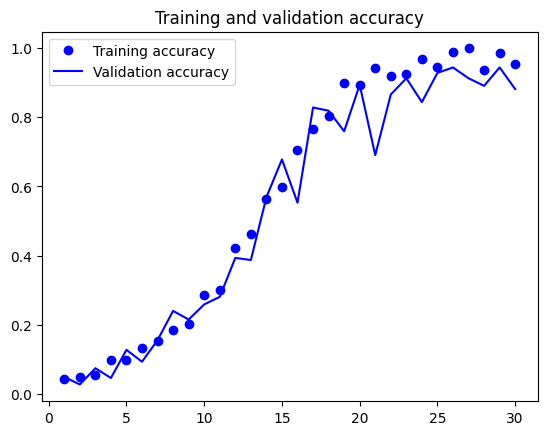

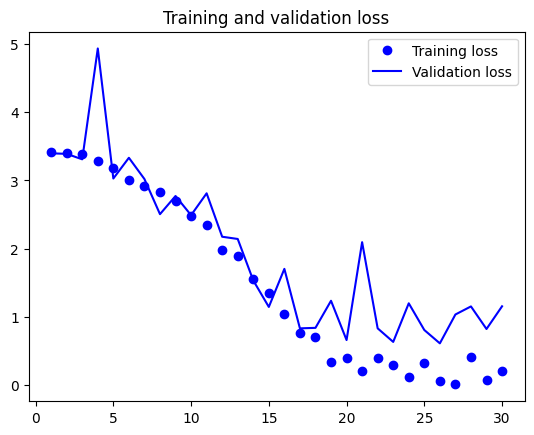

In [15]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### Evaluación modelo

In [16]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 811ms/step - accuracy: 0.9627 - loss: 0.3693
Test accuracy: 0.961
